In [1]:
from game import Game
from basic_env import Basic_env
from e_greedy_policy import E_Greedy_Policy
from greedy_policy import Greedy_Policy
from q_learning import Q_learning

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import random

- Q-Learning has been written in a separate module (q_learning.py) and imported above.
- So have the epsilon-greedy and greedy policies.

In [2]:
def createBasicEnv():
    types_file = 'type_advs.csv'
    moves_file = 'BasicEnvData/selected_moves.csv'
    poke_file = 'BasicEnvData/selected_poke_data.csv'
    trainer_file = 'BasicEnvData/selected_trainers.csv'
    cpu_damage_enabled = False
    cpu_all_moves = False
    game = Game("Ash", "Elite_four", poke_file, trainer_file, 
                moves_file, types_file, cpu_damage_enabled, cpu_all_moves)

    return Basic_env(game)

# Train One Epsiode:

In [3]:
def train_q_one_episode(envir, qlearn, epolicy, gpolicy, verbose):
    
    s = envir.reset()
    done = False

    # In this example, we update epsilon after each step
    while not done:
        
        # Action chosen using e-greedy policy:
        action = epolicy(s, qlearn.q_values, envir.game.trainer_team[0].moves)
        s_next, r, done = envir.move_turn(action, verbose)
        
        # Next action choice provided by greedy policy:
        action_greedy = gpolicy(s_next, qlearn.q_values, envir.game.trainer_team[0].moves)

        a_index = moves_to_index[action.name]
        a_greedy_index = moves_to_index[action_greedy.name]

        qlearn.update_values(s, a_index, r, s_next, a_greedy_index)
        epolicy.update_epsilon()

        s = s_next
    

# Run Experiment Functions:

In [16]:
def run_single_exp(envir, policy, q_values):
    
    state = envir.reset()
    done = False
    
    while not done:
        
        action = policy(state, q_values, envir.game.trainer_team[0].moves)
        state, reward, done = envir.move_turn(action, False)
                
    run_len, super_eff_moves, turn_max_boost_ach, potions_used, total_reward, outcome  = envir.return_ep_metrics()
    
    return total_reward, run_len, super_eff_moves, turn_max_boost_ach

In [17]:
def run_experiments(envir, policy, policy_eval_algo, number_exp):
    
    all_rewards = []
    run_length = []
    super_eff_moves = []
    max_boost_turn = []
    
    
    for n in range(number_exp):
        
        final_reward, run_len, super_eff, turn_max = run_single_exp(envir, 
                                                        policy, policy_eval_algo.q_values)
        all_rewards.append(final_reward)
        run_length.append(run_len)
        super_eff_moves.append(super_eff)
        max_boost_turn.append(turn_max)
    
    mean_reward = np.mean(all_rewards)
    std_reward = np.std(all_rewards)
    mean_run = np.mean(run_length)
    mean_super = np.mean(super_eff_moves)
    mean_boost = np.mean(max_boost_turn)
    
    return mean_reward, std_reward, mean_run, mean_super, mean_boost

# Define Environment:

In [18]:
basic_env = createBasicEnv()
epolicy = E_Greedy_Policy(1, 0.001, basic_env)
gpolicy = Greedy_Policy(1, basic_env)
qlearn = Q_learning(epolicy, basic_env, 0.9, 0.1, 4)

In [19]:
moves_to_index = {basic_env.game.trainer_team[0].moves[0].name: 0,
                    basic_env.game.trainer_team[0].moves[1].name: 1,
                    basic_env.game.trainer_team[0].moves[2].name: 2,
                    basic_env.game.trainer_team[0].moves[3].name: 3,
                    }

In [27]:
# Un-comment this cell to see a print out of one episode (i.e. one battle)
#train_q_one_episode(basic_env, qlearn, epolicy, gpolicy, True)

# Run Q-Learning:

In [21]:
episode_no_lst = []
mean_rew_lst = []
std_rew_lst = []
turns_taken_lst = []
super_eff_lst = []
turn_max_atk_lst = []

for episode in range(2001):
    
    train_q_one_episode(basic_env, qlearn, epolicy, gpolicy, False)
    
    if ( episode % 2000 ) == 0:
        
        mean_reward, std_reward, mean_run, mean_super, mean_boost = run_experiments(basic_env, 
                                                                        gpolicy, qlearn, 100)
        
        print('Episode:',episode, '| Mean Reward:', mean_reward,
              '| Std. Reward: {:.2f}'.format(std_reward), '| Mean Turns Taken:',  mean_run,
              '|\nMean Super Effective Moves Used:',  mean_super, 
              '| Mean Turn Reached Max Attack Boost:',  mean_boost, )
        
        # Append results to lists for plotting later:
        episode_no_lst.append(episode)
        mean_rew_lst.append(mean_reward)
        std_rew_lst.append(std_reward)
        turns_taken_lst.append(mean_run)
        super_eff_lst.append(mean_super)
        turn_max_atk_lst.append(mean_boost)

Episode: 0 | Mean Reward: -110.0 | Std. Reward: 0.00 | Mean Turns Taken: 100.0 |
Mean Super Effective Moves Used: 0.0 | Mean Turn Reached Max Attack Boost: 12.49
Episode: 2000 | Mean Reward: 88.25 | Std. Reward: 2.30 | Mean Turns Taken: 31.75 |
Mean Super Effective Moves Used: 21.34 | Mean Turn Reached Max Attack Boost: 4.0


# Displaying the State Value Matrix:

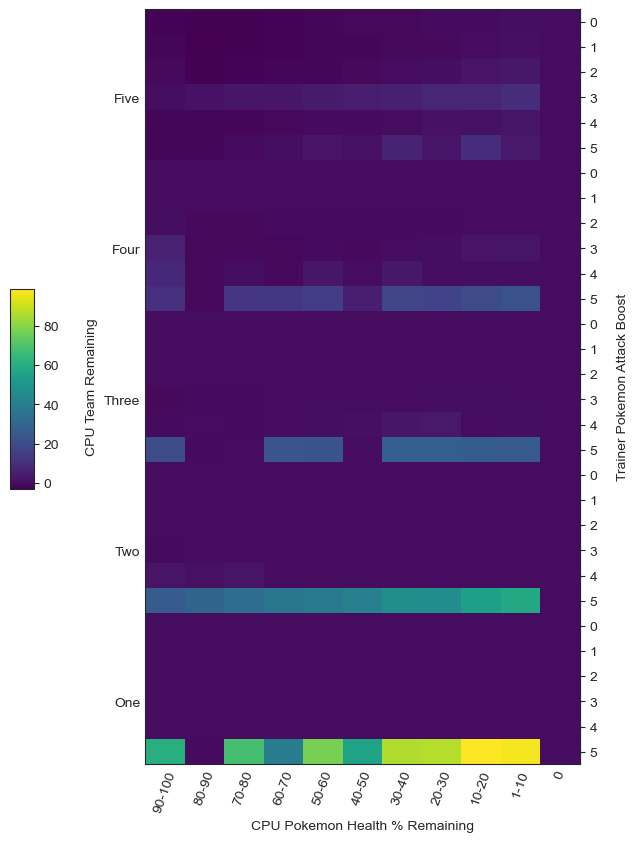

In [181]:
fig, ax = plt.subplots(figsize = (6,10), dpi=100)

vals = qlearn.display_values()


cmap = plt.cm.viridis
im1 = ax.imshow( vals, aspect = 'auto', cmap=cmap)

ticks_x = ['90-100', '80-90', '70-80', '60-70', '50-60', 
          '40-50', '30-40', '20-30', '10-20', '1-10', '0']
ticks_y = ['', 'Five', '', 'Four', '', 'Three', '', 'Two', '', 'One']
ticks_dual_y = []

for i in range(5):
    for j in range(6):
        tick_mark = j
        ticks_dual_y.append(str(tick_mark))
    
dual_y = ax.secondary_yaxis('right', ylabel = "\nTrainer Pokemon Attack Boost")
plt.yticks(np.arange(0, 29, step = 3), ticks_y)
plt.xticks(np.arange(0, 11, step = 1), ticks_x, rotation=70)
dual_y.set_yticks(np.arange(0, 30, step = 1))
dual_y.set_yticklabels(ticks_dual_y) 
ax.tick_params(axis='both', which='both', length=0)

plt.ylabel("CPU Team Remaining")
plt.xlabel("CPU Pokemon Health % Remaining")

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([-0.1, 0.4, 0.04, 0.2])
fig.colorbar(im1, cax=cbar_ax)
#plt.savefig('Figures/Basic_env_Q/SVM_Optimal.png', bbox_inches='tight')
plt.show()

# Scaling Q-Table and Plotting:

In [10]:
def scale_rows(qtable):
    for row in range(len(qtable)):
        # Definining Scaler:
        scaler = MinMaxScaler()

        # Fitting scaler on a row within Q-table (reshaping before and then after):
        scaled_row = scaler.fit_transform(qtable[row].reshape(-1, 1)).reshape(1,-1)

        qtable[row] = scaled_row

In [11]:
Q_table = qlearn.q_values
scale_rows(Q_table)

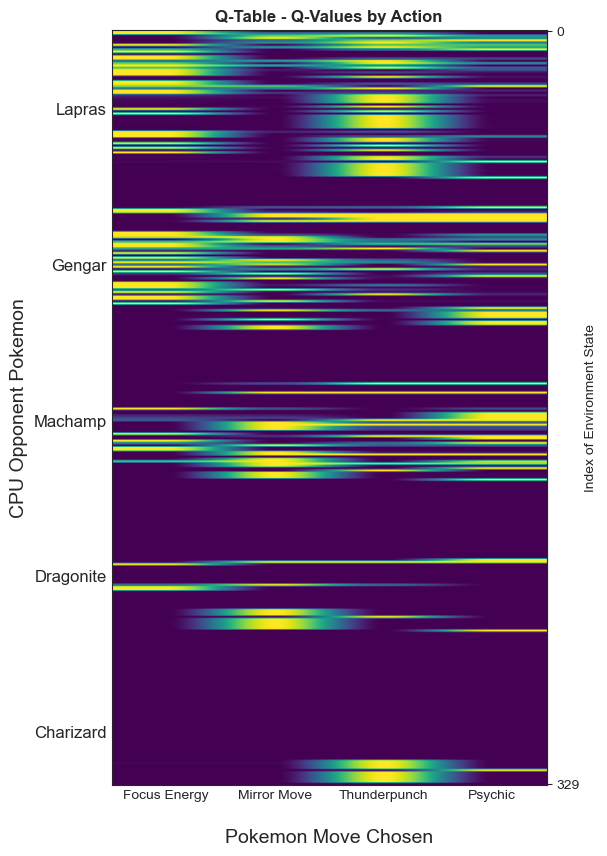

In [208]:
fig, ax = plt.subplots(figsize = (6,10), dpi=100)

ax.imshow( Q_table, vmin = 0, vmax = 1, aspect = 'auto', cmap = 'viridis')

ticks_x = ['Focus Energy', 'Mirror Move', 'Thunderpunch', 'Psychic']
ticks_y = ['', 'Lapras', '', 'Gengar', '', 'Machamp', '', 'Dragonite', '', 'Charizard']
    
dual_y = ax.secondary_yaxis('right', ylabel = "Index of Environment State")

plt.yticks(np.arange(0, 330, step = 34), ticks_y, fontsize=12)
plt.xticks(np.arange(0, 4, step = 1), ticks_x, fontsize=10)
dual_y.set_yticks(np.arange(0, 658, step = 329))
ax.tick_params(axis='both', which='both', length=0)
fig.subplots_adjust(right=0.85)
plt.ylabel("CPU Opponent Pokemon", fontsize=14)
plt.xlabel("\nPokemon Move Chosen", fontsize=14)
plt.title("Q-Table - Q-Values by Action", fontweight='bold')
#plt.savefig('Figures/Opt_QTable.png', bbox_inches='tight')
plt.show()

# Plotting Results Over Episodes:

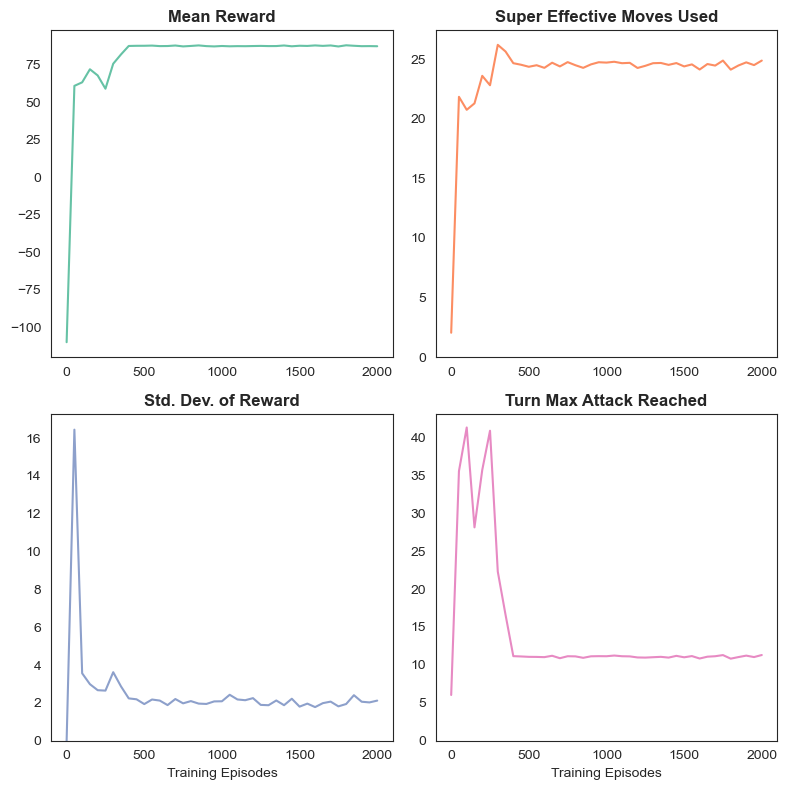

In [13]:
sns.set_style("white")

fig, ax = plt.subplots(2, 2, figsize = (8,8), dpi=100)
ax = ax.flatten()

sns.lineplot(x = episode_no_lst, y=mean_rew_lst, ax = ax[0], color = '#66c2a5')
sns.lineplot(x = episode_no_lst, y=super_eff_lst, ax = ax[1], color = '#fc8d62')
sns.lineplot(x = episode_no_lst, y=std_rew_lst, ax = ax[2], color = '#8da0cb')
sns.lineplot(x = episode_no_lst, y=turn_max_atk_lst, ax = ax[3], color = '#e78ac3')

col_labels = ['Mean Reward', 'Super Effective Moves Used', 
              "Std. Dev. of Reward", "Turn Max Attack Reached"]

for i in range(len(col_labels)):
    ax[i].set_title(col_labels[i], fontweight = 'bold', fontsize=12)
                    
for i in range(1,4):
    ax[i].set_ylim(0)

for i in range(2,4):
    ax[i].set_xlabel("Training Episodes", fontsize=10)

plt.tight_layout()
#plt.savefig('Figures/Optimal_Results.png', bbox_inches='tight')
plt.show()

# Random Policy Comparison:

In [25]:
def run_one_episode_random(env):
    state = env.reset()
    done = False
    while not done:
        a_idx = random.randint(0,3)
        move_pool = env.game.trainer_team[0].moves
        action = move_pool[a_idx]
        s_nxt, r, done = env.move_turn(action, False)
        state = s_nxt

In [26]:
# Running an example where every action choice is picked randomly:

mean_rew_lst_rand = []
super_eff_lst_rand = []
turn_max_atk_lst_rand = []
mean_run_len_rand = []

for i in range(100):
    run_one_episode_random(basic_env)
    run_len, super_eff_moves, turn_max_boost_ach, _, total_reward, _  = basic_env.return_ep_metrics()
        
    # Append results to lists for plotting later:
    mean_rew_lst_rand.append(total_reward)
    super_eff_lst_rand.append(super_eff_moves)
    turn_max_atk_lst_rand.append(turn_max_boost_ach)
    mean_run_len_rand.append(run_len)

std_reward_rand = np.std(mean_rew_lst_rand)
mean_rew_rand = np.mean(mean_rew_lst_rand)
mean_se_rand = np.mean(super_eff_lst_rand)
mean_maxatt_rand = np.mean(turn_max_atk_lst_rand)
mean_turn_len = np.mean(mean_run_len_rand)

In [194]:
print(mean_rew_rand)
print(std_reward_rand)
print(mean_se_rand)
print(mean_maxatt_rand)

60.18
6.456593529098762
16.13
19.61


In [195]:
# Same stats from 100 episodes using a greedy policy after Q-Learning for 1,000 episodes:
print(mean_rew_lst[-1])
print(std_rew_lst[-1])
print(super_eff_lst[-1])
print(turn_max_atk_lst[-1])

89.15
1.6085707942145409
22.89
4.0
